# ML Feature enginerring - SelectKbest

In [77]:
%matplotlib inline
%run ../talibref.py
%run ensemble.py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Get data

In [78]:
#df=pd.read_csv("data/IYZ.csv")
ticker = '^GSPC'
startdate=datetime.date(2010, 1, 1)
enddate=datetime.date.today()
df = generate_ticker_data(ticker, startdate, enddate)

Available data: Ticker(^GSPC) from 1950.01.03 to 2015.11.27
Usable data: Ticker(^GSPC) from 1962.05.28 to 2015.11.27 
Returned data: Ticker(^GSPC) from 2010.01.04 to 2015.11.27 
Save path: data/^GSPC_from_2010.01.04_2015.11.27.csv


In [79]:
dftouse=df.copy()

### Feature Engineering

In [80]:
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']

In [81]:
INDICATORS=[]
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)

In [82]:
STANDARDIZABLE = []
for v in df.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

In [83]:
################################################
# Code to add signals from other tickers
################################################

# Additional tickers to consider
moreTickers = [
               #'^GSPC', #S&P500
               '^dji',  #Dow Jones Industrials
               '^IXIC', #Nasdaq
               'OIL'   #Oil price ETF
              ]

# Signals for additional tickers
STANDARDIZABLE_TO_ADD = ['roc']
INDICATORS_TO_ADD = ['sar_signal']


def addDataFromOtherTicker(tickerPlus):
    dfPlus = generate_ticker_data(tickerPlus, startdate, enddate)
    if df.shape == dfPlus.shape:
        dfPluss = dfPlus.copy()
        dfPluss = dfPluss[STANDARDIZABLE_TO_ADD+INDICATORS_TO_ADD]
        STANDARDIZABLE2 = STANDARDIZABLE_TO_ADD[:]
        INDICATORS2 = INDICATORS_TO_ADD[:]
        for p in STANDARDIZABLE2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]*1.0
            STANDARDIZABLE.append(renamed)
        for p in INDICATORS2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]
            INDICATORS.append(renamed)
    else:
        print "Data for additional tickers doesn't match data frame for sector of interest."

for tick in moreTickers:
    print "####### Loading data for "+tick+"...."
    addDataFromOtherTicker(tick)    
    time.sleep(0.5)
    
dftouse.head()

####### Loading data for ^dji....
Available data: Ticker(^dji) from 1985.01.29 to 2015.11.27
Usable data: Ticker(^dji) from 1987.10.15 to 2015.11.27 
Returned data: Ticker(^dji) from 2010.01.04 to 2015.11.27 
Save path: data/^dji_from_2010.01.04_2015.11.27.csv
####### Loading data for ^IXIC....
Available data: Ticker(^IXIC) from 1971.02.05 to 2015.11.27
Usable data: Ticker(^IXIC) from 1973.11.26 to 2015.11.27 
Returned data: Ticker(^IXIC) from 2010.01.04 to 2015.11.27 
Save path: data/^IXIC_from_2010.01.04_2015.11.27.csv
####### Loading data for OIL....
Available data: Ticker(OIL) from 2006.08.16 to 2015.11.27
Usable data: Ticker(OIL) from 2007.06.05 to 2015.11.27 
Returned data: Ticker(OIL) from 2010.01.04 to 2015.11.27 
Save path: data/OIL_from_2010.01.04_2015.11.27.csv


,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,1136.520020,True,0.003116,1091.760010,False,-0.036390,1,1135.412908,1112.163995,1088.915083,0.947892,4.180842,False,False,False,1,1096.908204,1040.171066,1029.228907,1,1,1081.721667,1077.963793,1057.174653,1,1,1114.066084,1,14.037395,27.918521,21.452845,False,True,1,96,1,94.220152,1,8.643297,7.804442,0.838855,1,0.719231,1,68.615369,0,3.367458,0,62.317285,0,60.478256,0,-2.200563,0,1.504123e+09,1,56.569007,61.493725,0,91.611115,52.015801,0,0.106599,1,1127.806681,1171.873373,1121.743368,1177.936686,1077.676676,1222.003378,1071.613363,1,2.674556,1,5.888391,1,11.120401,1
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,1137.140015,True,0.000546,1096.780029,False,-0.034966,0,1139.032263,1113.690997,1088.349731,0.950432,4.550861,False,False,False,1,1098.461608,1041.447211,1030.296480,1,1,1082.616342,1079.397352,1059.647315,1,1,1114.810059,1,14.202133,28.457773,20.462397,False,True,1,100,1,126.113445,1,9.350417,8.113637,1.236780,1,0.834033,1,67.403473,0,3.088524,0,63.714966,0,61.757953,0,-0.257275,0,2.474738e+09,1,65.580311,57.159185,0,100.000000,63.870372,0,0.106707,1,1134.270020,1184.800049,1131.910034,1187.160035,1081.380005,1237.690064,1079.020019,1,2.353882,1,4.386692,1,10.696517,1
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,1141.689941,True,0.004001,1092.170044,False,-0.039547,0,1142.197116,1115.385498,1088.573881,0.905692,4.807597,False,False,False,1,1099.978409,1042.714665,1031.359600,1,1,1083.853199,1080.949751,1061.702142,1,1,1116.560059,1,14.570131,29.192692,19.725088,False,True,1,72,1,124.785414,1,9.847329,8.460375,1.386954,1,0.982432,1,77.100210,0,2.072615,0,63.967752,0,60.072359,0,-4.524231,0,2.991095e+09,1,95.490211,72.546510,0,100.000000,97.203705,0,0.107008,1,1136.759969,1189.779948,1134.329997,1192.209920,1081.310018,1245.229899,1078.880046,1,1.531956,1,2.834666,1,13.871370,1
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,1144.979980,True,0.002882,1097.500000,False,-0.038706,0,1144.753439,1117.872998,1090.992557,0.943016,4.809212,False,False,False,1,1101.614155,1044.025596,1032.457414,1,1,1085.699077,1082.533350,1064.019010,1,1,1121.086035,1,15.183552,29.204972,18.221856,False,True,1,76,1,117.992268,1,10.487385,8.865777,1.621608,1,1.115174,1,77.348299,0,2.117129,0,65.848108,0,64.921007,0,-1.585057,0,4.375609e+09,1,96.100927,85.723816,0,100.000000,100.000000,0,0.107545,1,1138.489949,1193.239909,1134.519938,1197.209920,1079.769978,1251.959880,1075.799967,1,1.356251,1,2.103288,1,11.928517,1
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,1146.979980,True,0.001747,1084.530029,False,-0.052796,0,1147.698801,1120.324500,1092.950198,0.950340,4.886852,False,False,False,1,1103.314776,1045.362740,1033.577042,1,1,1087.820177,1084.215938,1066.332116,1,1,1125.360821,1,15.992102,29.378840,17.068726,False,True,1,80,1,136.783150,1,11.131792,9.318980,1.812812,1,1.220273,1,91.143803,0,2.176533,0,67.181768,0,72.499411,0,-0.796030,0,5.816002e+09,1,95.794862,95.795333,0,100.000000,100.000000,0,0.108320,1,1142.196655,1200.653321,1139.003296,1203.846680,1080.546630,1262.303346,1077.353271,1,1.449872,1,2.094166,1,

In [84]:
dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values
mask.shape, mask.sum()

((1487,), 1258)

#### 1.2 Standardize the data

Use the mask to compute the training and test parts of the dataframe. Use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. Then use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [85]:
#your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,-1.216617,-1.185781,-1.185834,-1.161915,0.201481,1136.520020,True,0.003116,1091.760010,False,-0.036390,1,-1.289388,-1.224798,-1.155333,1.053938,-0.570004,False,False,False,1,-1.263584,-1.401935,-1.414482,1,1,-1.352879,-1.319344,-1.371833,1,1,-1.203334,1,-1.124553,0.421141,-0.249304,False,True,1,1.087692,1,0.619006,1,0.286248,0.235957,0.196113,1,0.283421,1,0.819616,0,1.022709,0,0.589606,0,0.287822,0,1.052558,0,-0.175807,1,-0.171535,0.010357,0,0.847749,-0.116503,0,0.744443,1,-1.178008,-1.223377,-1.036972,-1.362274,-0.974877,-1.388255,-0.838285,1,0.854181,1,1.648852,1,2.097356,1
1,2010-01-05,-1.161492,-1.176320,-1.141084,-1.149837,-1.420557,1137.140015,True,0.000546,1096.780029,False,-0.034966,0,-1.276828,-1.219504,-1.157283,1.061674,-0.448654,False,False,False,1,-1.258092,-1.397185,-1.410401,1,1,-1.349647,-1.314126,-1.362888,1,1,-1.200770,1,-1.101990,0.502786,-0.389201,False,True,1,1.152412,1,0.921261,1,0.345665,0.264288,0.289976,1,0.369593,1,0.743306,0,0.922154,0,0.714933,0,0.401857,0,1.113819,0,0.187180,1,0.160817,-0.162430,0,1.046842,0.238352,0,0.745855,1,-1.155888,-1.180795,-1.003589,-1.330846,-0.962368,-1.337251,-0.814425,1,0.730416,1,1.176547,1,2.019937,1
2,2010-01-06,-1.151050,-1.167544,-1.126430,-1.147715,1.262307,1141.689941,True,0.004001,1092.170044,False,-0.039547,0,-1.265845,-1.213630,-1.156510,0.925394,-0.364457,False,False,False,1,-1.252729,-1.392468,-1.406338,1,1,-1.345177,-1.308476,-1.355455,1,1,-1.194737,1,-1.051588,0.614055,-0.493343,False,True,1,0.699370,1,0.908675,1,0.387419,0.296058,0.325399,1,0.480984,1,1.353885,0,0.555921,0,0.737600,0,0.251652,0,0.979306,0,0.380285,1,1.263944,0.450951,0,1.046842,1.236154,0,0.749785,1,-1.147366,-1.164391,-0.995642,-1.313639,-0.962604,-1.312736,-0.814876,1,0.413191,1,0.688413,1,2.599800,1
3,2010-01-07,-1.149132,-1.156334,-1.135414,-1.132147,1.584491,1144.979980,True,0.002882,1097.500000,False,-0.038706,0,-1.256974,-1.205006,-1.148168,1.039086,-0.363927,False,False,False,1,-1.246945,-1.387588,-1.402142,1,1,-1.338508,-1.302712,-1.347074,1,1,-1.179136,1,-0.967573,0.615914,-0.705669,False,True,1,0.764090,1,0.844296,1,0.441200,0.333203,0.380750,1,0.580622,1,1.369507,0,0.571968,0,0.906209,0,0.683719,0,1.071961,0,0.898060,1,1.286468,0.976235,0,1.046842,1.319859,0,0.756805,1,-1.141445,-1.152994,-0.995019,-1.296602,-0.967806,-1.290855,-0.824798,1,0.345377,1,0.458384,1,2.244953,1
4,2010-01-08,-1.134581,-1.146289,-1.118675,-1.120890,0.631958,1146.979980,True,0.001747,1084.530029,False,-0.052796,0,-1.246753,-1.196507,-1.141417,1.061395,-0.338464,False,False,False,1,-1.240932,-1.382611,-1.397863,1,1,-1.330844,-1.296588,-1.338706,1,1,-1.164400,1,-0.856832,0.642239,-0.868544,False,True,1,0.828811,1,1.022379,1,0.495348,0.374727,0.425851,1,0.659511,1,2.238175,0,0.593383,0,1.025796,0,1.359036,0,1.096835,0,1.436732,1,1.275180,1.377713,0,1.046842,1.319859,0,0.766932,1,-1.128760,-1.128574,-0.980297,-1.273987,-0.965183,-1.257224,-0.819794,1,0.381511,1,0.455515,1,1.645234,1


We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

In [86]:
#lcols=list(dftouse.columns)
#lcols.remove(u'results')
lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
print len(lcols)

76


### EDA for the data

We create a variable `ccols` which contains all variables not in our indicators list

In [87]:
ccols=[]
for c in lcols:
    if c not in INDICATORS and c not in IGNORE:
        ccols.append(c)
print len(ccols), len(INDICATORS)

47 29


In [88]:
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

In [89]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        #print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        #print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [90]:
X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [91]:
print "whole data set", dftouse['results'].mean()
print "training set", dftouse['results'][mask].mean(), "test set", dftouse['results'][~mask].mean()

whole data set 0.429724277068
training set 0.435612082671 test set 0.397379912664


#####our data is not very asymmetric, but we might still want to balance the trainset

### Balancing train set to test set for training, 
### intended to be used with SVM only

In [92]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
print Xtrain_new.shape, ytrain_new.shape

reuse_split_balanced=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

548 710
(1096, 76) (1096,)


## Test all classifiersres using SelectKbest

In [93]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate(clf):
    clf.fit(Xtrain,ytrain)
    training_accuracy = accuracy_score(ytrain, clf.predict(Xtrain))
    test_accuracy = accuracy_score(ytest, clf.predict(Xtest))
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    _,_,ROI_base,_,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'result_baseline', 'close', False, [1])
    _,_,ROI_long,_,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', False, [1])
    _,_,ROI_lgst,_,signals = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', False, [1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst, signals

def print_result(clfpipe):     
    print "Number of features: {0}".format(clfpipe.get_params()['selectk__k'])
    print "Features: {0}".format(np.array(lcols)[clfpipe.named_steps['selectk'].get_support()].tolist())
    r = evaluate(clfpipe)
    print "train accuracy: {0}".format(r[0])
    print "test accuracy: {0}".format(r[1])
    print "ROI baseline: {0}".format(r[2])
    print "ROI long-only: {0}".format(r[3])
    print "ROI long-short: {0}".format(r[4])

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [95]:
%%time
max_number_featrues = 20
Long_ROI_result={}
Test_set_accuracies={}
scoring_func="accuracy"


print "#############====================== Log Regression =====================#############"
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR, _,_,_,_  = do_classify(pipeLR, {"selectk__k":range(1,max_number_featrues+1), 
                                        "LR__C": [1e-3, 1e-2, 1e-1, 1, 1e2],
                                        "LR__random_state": [111]}, 
                               dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)

print pipeLR.get_params()['LR__C']
print_result(pipeLR)
Long_ROI_result["log_regression"] = evaluate(pipeLR)[3]
Test_set_accuracies["log_regression"] = evaluate(pipeLR)[1]

#############====================== Log Regression =====================#############
0.1
Number of features: 9
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastk', 'stoch_fastd']
train accuracy: 0.715421303657
test accuracy: 0.729257641921
ROI baseline: 0.0127640624
ROI long-only: 0.0341968994
ROI long-short: 0.0683327884
CPU times: user 11.5 s, sys: 138 ms, total: 11.6 s
Wall time: 11.7 s


In [96]:
%%time
print "#############====================== RBF SVM ===========================#############"
pipesvm2 = Pipeline([('selectk', selectk), ('svm2', SVC())])
pipesvm2,_,_,_,_  = do_classify(pipesvm2, {"selectk__k":[2,3,4,5,6,7,9,12,18,25], 
                                            "svm2__C": [1e-2,1e-1,1,1e2,1e4,1e5,1e6,1e7, 1e8,1e9], 
                                            "svm2__gamma": [ 1e-7,1e-8, 1e-9, 1e-10],
                                            "svm2__random_state": [111]}, 
                                 dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print pipesvm2.get_params()['svm2__C'], pipesvm2.get_params()['svm2__gamma']
print_result(pipesvm2)
Long_ROI_result["RBF_SVM"] = evaluate(pipesvm2)[3]
Test_set_accuracies["RBF_SVM"] = evaluate(pipesvm2)[1]

#############====================== RBF SVM ===========================#############
100000000.0 1e-07
Number of features: 9
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastk', 'stoch_fastd']
train accuracy: 0.712241653418
test accuracy: 0.733624454148
ROI baseline: 0.0127640624
ROI long-only: 0.0822361209
ROI long-short: 0.1619561898
CPU times: user 1min 56s, sys: 858 ms, total: 1min 57s
Wall time: 1min 59s


In [97]:
%%time
print "#############====================== Random Forest =====================#############"
pipeRF = Pipeline([('selectk', selectk), ('RF', RandomForestClassifier())])
pipeRF,_,_,_,_  = do_classify(pipeRF, {"selectk__k": [5,6,7,8,9,10],
                                       "RF__max_depth": [3,5,7], 
                                       "RF__n_estimators": [5,10,20],
                                       "RF__max_features": [1,2,3],
                                       "RF__random_state": [111]}, 
                              dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)

print pipeRF.get_params()['RF__max_depth'], pipeRF.get_params()['RF__n_estimators'], pipeRF.get_params()['RF__max_features']
print_result(pipeRF)
Long_ROI_result["Random_forest"] = evaluate(pipeRF)[3]
Test_set_accuracies["Random_forest"] = evaluate(pipeRF)[1]

#############====================== Random Forest =====================#############
7 20 3
Number of features: 10
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastk', 'stoch_fastd', 'srsi_signal']
train accuracy: 0.868044515103
test accuracy: 0.703056768559
ROI baseline: 0.0127640624
ROI long-only: 0.0760422853
ROI long-short: 0.1236154911
CPU times: user 31.7 s, sys: 434 ms, total: 32.2 s
Wall time: 32.2 s


In [98]:
%%time
print "#############====================== Extra Trees= =====================#############"
pipeET = Pipeline([('selectk', selectk), ('ET', ExtraTreesClassifier())])
pipeET, _,_,_,_  = do_classify(pipeET, {"selectk__k": [5,6,7,8,9,10,15],
                                        "ET__max_depth": [1,2,3,5,7,10,15], 
                                        "ET__n_estimators": [3,5,10],
                                        "ET__max_features": [1,2,3],
                                        "ET__random_state": [111]}, 
                               dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)
print "ET__max_depth: {0}".format(pipeET.get_params()['ET__max_depth']) 
print "ET__n_estimators: {0}".format(pipeET.get_params()['ET__n_estimators']) 
print "ET__max_features: {0}".format(pipeET.get_params()['ET__max_features']) 
print_result(pipeET)
Long_ROI_result["Extra_Trees"] = evaluate(pipeET)[3]
Test_set_accuracies["Extra_Trees"] = evaluate(pipeET)[1]

#############====================== Extra Trees= =====================#############
ET__max_depth: 10
ET__n_estimators: 10
ET__max_features: 3
Number of features: 10
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastk', 'stoch_fastd', 'srsi_signal']
train accuracy: 0.893481717011
test accuracy: 0.733624454148
ROI baseline: 0.0127640624
ROI long-only: 0.0888351433
ROI long-short: 0.1643412579
CPU times: user 58.8 s, sys: 1.26 s, total: 1min
Wall time: 1min


In [99]:
%%time
print "#############====================== Gaussian NB ==========================#############"
pipeNB = Pipeline([('selectk', selectk), ('NB', GaussianNB())])
pipeNB,_,_,_,_ = do_classify(pipeNB, {"selectk__k":range(1,max_number_featrues+1)}, 
                             dftouse, lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print_result(pipeNB)
Long_ROI_result["Gaussian_NB"] = evaluate(pipeNB)[3]
Test_set_accuracies["Gaussian_NB"] = evaluate(pipeNB)[1]

#############====================== Gaussian NB ==========================#############
Number of features: 8
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastd']
train accuracy: 0.690779014308
test accuracy: 0.724890829694
ROI baseline: 0.0127640624
ROI long-only: 0.005639941
ROI long-short: 0.0055718255
CPU times: user 2.24 s, sys: 54.6 ms, total: 2.3 s
Wall time: 2.3 s


In [100]:
#%%time
#print "#############====================== Gradient Boosting ====================#############"
#pipeGB = Pipeline([('selectk', selectk), ('GB', GradientBoostingClassifier())])
#pipeGB, _,_,_,_  = do_classify(pipeGB, {"selectk__k":range(1,max_number_featrues+1), 
#                                        "GB__n_estimators": [5,10,20,40],
#                                        "GB__learning_rate": [0.1,0.5,1.0],
#                                        "GB__random_state": [111]}, 
#                               dftouse,lcols, u'results',1, reuse_split=reuse_split)
#print pipeGB.get_params()['GB__n_estimators'], pipeGB.get_params()['GB__learning_rate']
#print_result(pipeGB)
#Long_ROI_result["Gradient_bossting"] = evaluate(pipeGB)[3]
#Test_set_accuracies["Gradient_bossting"] = evaluate(pipeGB)[1]

In [101]:
eclf = EnsembleClassifier(clfs=[pipeLR, pipesvm2, pipeRF, pipeET, pipeNB], voting='hard')
r = evaluate(eclf)
Long_ROI_result["Ensemble"] = r[3]
Test_set_accuracies["Ensemble"] = r[1]
print "train accuracy: {0}".format(r[0])
print "test accuracy: {0}".format(r[1])
print "ROI baseline: {0}".format(r[2])
print "ROI long-only: {0}".format(r[3])
print "ROI long-short: {0}".format(r[4])

train accuracy: 0.765500794913
test accuracy: 0.724890829694
ROI baseline: 0.0127640624
ROI long-only: 0.0745051392
ROI long-short: 0.1312312501


In [102]:
print "---Test accuracy results---"
Test_set_accuracies

---Test accuracy results---


{'Ensemble': 0.72489082969432317,
 'Extra_Trees': 0.73362445414847166,
 'Gaussian_NB': 0.72489082969432317,
 'RBF_SVM': 0.73362445414847166,
 'Random_forest': 0.70305676855895194,
 'log_regression': 0.72925764192139741}

In [103]:
print "ROI baseline: {0}".format(evaluate(pipeNB)[2])
print "---Long ROI results---"
Long_ROI_result

ROI baseline: 0.0127640624
---Long ROI results---


{'Ensemble': 0.07450513919999957,
 'Extra_Trees': 0.088835143299999794,
 'Gaussian_NB': 0.005639940999999999,
 'RBF_SVM': 0.082236120899999696,
 'Random_forest': 0.076042285299999637,
 'log_regression': 0.03419689939999989}

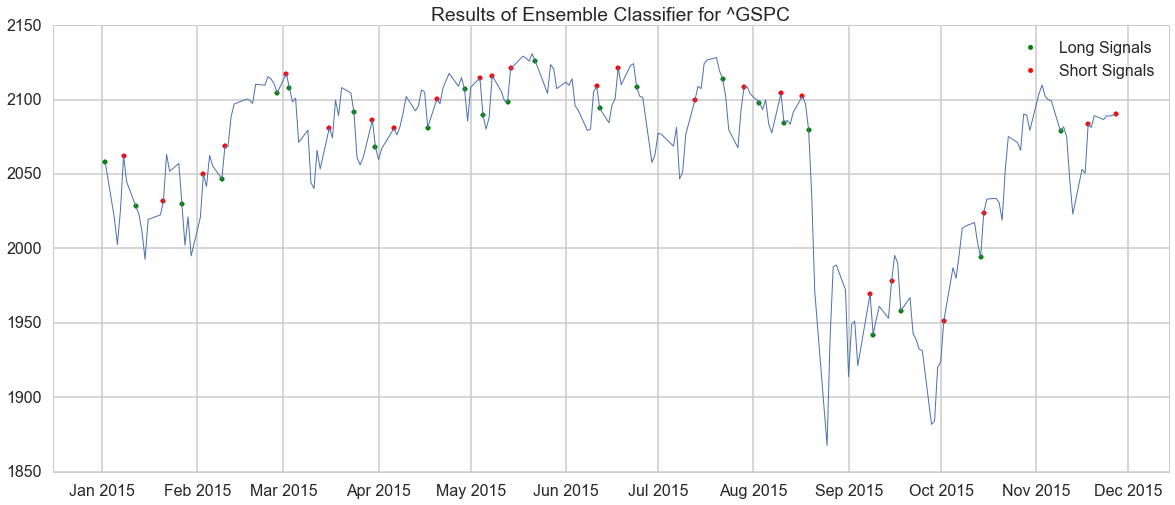

In [105]:
def plot_signal(model, title):
    fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
    ax0.plot(df.date[~mask], df.close[~mask], lw=1)
    short_days=zip(*evaluate(pipeLR)[5][0])[0]
    short_prices=zip(*evaluate(pipeLR)[5][0])[1]
    long_days=zip(*evaluate(pipeLR)[5][1])[0]
    long_prices=zip(*evaluate(pipeLR)[5][1])[1]
    ax0.scatter(long_days, long_prices, color='g', label="Long Signals") 
    ax0.scatter(short_days, short_prices, color='r', label="Short Signals")
    ax0.legend(frameon=False, loc='upper right')
    ax0.set_title(title)
    
plot_signal(pipeLR, 'Results of Ensemble Classifier for '+ticker)